In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp

def is_consensus(x, fix):
    res = True
    count = 0
    for i in range(1, len(x)):
        if x[i-1] != x[i]:
            count += 1
    if count > 2:
        res = False
    return res
def clusters(x0,eps2, fix = {}):
    count = [x0[0]]
    l=0
    for i in range(1,len(x0)):
        if i not in fix:
            for j in range (len(count)):
                if np.abs(x0[i] - count[j])<eps2:
                    l+=1
            if l==0:
                count.append(x0[i])
            l=0
    return np.array(count)

def cl_capacity(x0,cls,eps2, fix = {}):
    capacity = []
    l=0
    for i in range(len(cls)):
            for j in range (len(x0)):
                if j not in fix:
                    if np.abs(x0[j] - cls[i])<eps2:
                        l+=1
            capacity.append(l)
            l=0
    if sum(capacity)>len(x0):
        raise Error
    return np.array(capacity)

def compare (x ,y, eps):
    result = 1
    for k in range(len(x)):
        if abs(x[k] - y[k]) >= eps:
            result = 0
    return bool(result)

def insert_agent(x, ind):
    if  ind != 0:
        opinion = (x[ind]+x[ind-1])/2
    else:
        opinion = x[ind]
    _X = np.insert(x,ind,opinion)
    return _X

def new_op(x, i, eps):
    count = 1
    summ = x[i]
    for k in range(len(x)):
        if (abs(x[i] - x[k]) < eps) and (i != k):
            #print(i, j, x[i], x[j])
            summ += x[k]
            count += 1
    #print(summ, count)
    return summ/count

def pair_count (x0, fix = {}):
    count = [0, 0]
    for i in range(len(x0)):
        if i not in fix:
            if x0[i] >= 0.5:
                count[0] += 1
            else:
                count[1] += 1
    #count[0] = count[0]/len(x0)
    #count[1] = count[1] / len(x0)
    return count

def Hen_Kr (x0, eps, eps2,fix, v):
    X = [np.array(x0)]
    t = 0
    while True:
        X.append(np.zeros(len(x0)))
        t += 1
        for j in range(len(x0)):
            if j not in fix:
                X[t][j] = new_op(X[t - 1], j, eps)
            else:
                if X[t - 1][j] + v <= 1:
                    X[t][j] = X[t - 1][j] + v
                else:
                    X[t][j] = 1
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t

def find_fix(x0):
    diff = 1
    ind = 0
    for j in range (len(x0)):
        if (x0[j] - 0.5 < diff) and (x0[j] - 0.5 >= 0):
            ind = j
            diff = abs(0.5 - x0[j])
    return ind

def Hen_Kr_actm2_statistics (x0, eps, eps2,fix, v, prob):
    X = [np.array(x0)]
    t = 0
    consensus_value = 0
    consensus_time = 0
    consensus_flag = True
    pos0_6_time = 0
    pos0_6_flag = True
    while True:
        X.append(np.zeros(len(x0)))
        active_mask = bernoulli.rvs(p=prob, size=n)
        t += 1
        for j in range(len(x0)):
            if j not in fix and active_mask[j]==1:
                X_prev = np.copy(X[t -1])
                X_prev[active_mask==0]=0-2*eps - 2*eps2 
                X[t][j] = new_op(X_prev, j, eps)
                X[t][active_mask==0]=X[t-1][active_mask==0]
            else:
                if X[t - 1][j] + v <= 1:
                    X[t][j] = X[t - 1][j] + v
                else:
                    X[t][j] = 1
        if consensus_flag:
            ctrs = clusters(X[t],eps,fix_control)
            if len(ctrs) ==1:
                consensus_flag = False
                consensus_time = t
                consensus_value = X[t][0]
        if pos0_6_flag and np.all(X[t]>= 0.6):
            pos0_6_time = t
            pos0_6_flag = False
        if compare(X[t], X[t - 1], eps2):
            break
    return X, t, consensus_value, consensus_time, pos0_6_time

In [2]:
eps = 0.2
eps2 = 0.0001
n =50
p = 1
prob = 1

In [3]:
pp = np.array(range(5,11,1))
pp = pp/10
pp

array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [4]:
nn = np.array(range(10,210,10))
nn.shape[0]

20

In [9]:
ee = np.array(range(1,21,1))
ee = ee/20
nn = np.array(range(10,210,10))

prob = 0.5
#n = 50
na = float('nan')
cl_num_HK = np.zeros((nn.shape[0],ee.shape[0]))
cl_num_STHK = np.zeros((nn.shape[0],ee.shape[0]))

cl_col = np.zeros((nn.shape[0],ee.shape[0]))#cl_col[i] = количество  получаемых консенсусов для eps = ee[i]
cl_c_col = np.zeros((nn.shape[0],ee.shape[0]))
cl_diff = np.zeros((nn.shape[0],ee.shape[0]))
cl_d_c = np.zeros((nn.shape[0],ee.shape[0]))

count = 100

for j in trange(nn.shape[0]):
    n = nn[j]
    for _ in range(count):
        for i in range(ee.shape[0]):
            eps = ee[i]

            x0 = np.random.sample(n)
            x0.sort()
            start = pair_count(x0)

            fix_control = set({})
            v_c = 0

            X_control, t_control = Hen_Kr(x0,eps,eps2,fix_control, v_c)
            finish_c = pair_count(X_control[t_control])

            t_c_list = np.linspace(0, t_control, t_control + 1)
            c_cl = clusters(X_control[t_control], eps, fix_control)


            X, t, cons_value, cons_time, positive_time = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
            cltrs = clusters(X[t],eps,fix_control)
            finish = pair_count(X[t])
            t_list = np.linspace(0, t, t + 1)

            if len(c_cl) == 1:
                cl_c_col[j,i]+=1
            if len(cltrs)==1:
                cl_col[j,i] +=1

            cl_num_HK[j,i] +=len(c_cl)
            cl_num_STHK[j,i] +=len(cltrs)
        

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:41:34<00:00, 304.73s/it]


In [5]:
count = 100

ee = np.array(range(1,21,1))
ee = ee/20
nn = np.array(range(10,210,10))


prob = 0.5

cl_num_HK = np.load(f'cl_num_HK_{count}.npy', mmap_mode = 'r')
cl_num_STHK = np.load(f'cl_num_STHK_{count}.npy', mmap_mode = 'r')

cl_col = np.load(f'cl_col_{count}.npy', mmap_mode = 'r')
cl_c_col = np.load(f'cl_c_col_{count}.npy', mmap_mode = 'r')

In [ ]:

fig = plt.figure(facecolor='white', figsize=(6, 4))
plt.title(f'зависимость вероятности получения консенсуса в в HK и STHK от eps n={nn[4]}')
plt.xlabel('eps')
plt.ylabel('вероятность')
#plt.plot(nn, cl_num_HK/count,  '-o', label="HK")    
plt.plot(ee, cl_c_col[-6]/count,'-o', color ='green', label =f'HK n={nn[-6]}')
#for k in range (pp.shape[0]):
plt.plot(ee, cl_col[0,-1]/count, label=f'STHK prob = {pp[0]}')

plt.legend()
#plt.yticks(cl_col/count)
plt.xticks(ee)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

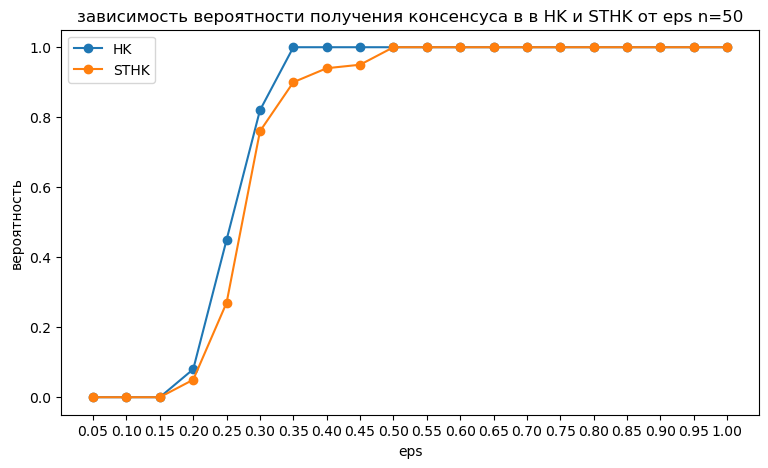

In [28]:
fig = plt.figure(facecolor='white', figsize=(9, 5))
plt.title(f'зависимость вероятности получения консенсуса в в HK и STHK от eps n={nn[4]}')
plt.xlabel('eps')
plt.ylabel('вероятность')
#plt.plot(nn, cl_num_HK/count,  '-o', label="HK")
plt.plot(ee, cl_c_col[4]/count, '-o', label ='HK')
plt.plot(ee, cl_col[0,4]/count, '-o', label='STHK')

plt.legend()
#plt.yticks(cl_col/count)
plt.xticks(ee)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

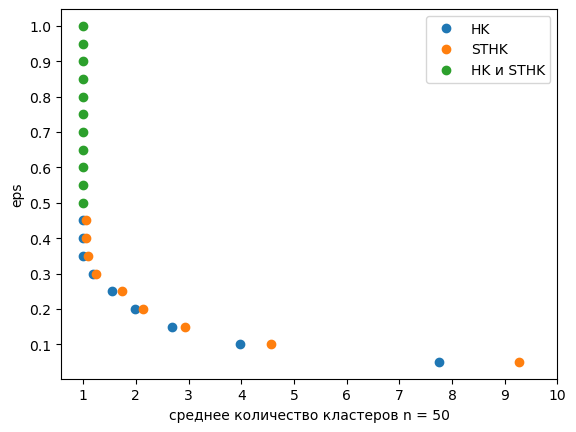

In [32]:
hk = np.array([cl_num_HK[4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]])
ek = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]]

sthk = np.array([cl_num_STHK[0,4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]])
est = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]]

both = np.array([cl_num_HK[4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]==cl_num_STHK[0,4,i]])
eb = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]==cl_num_STHK[0,4,i]]

plt.plot(hk/count, ek, 'o', label ="HK")
plt.plot(sthk/count, est, 'o', label = "STHK")
plt.plot(both/count, eb, 'o', label = "HK и STHK")
plt.xlabel(f'среднее количество кластеров n = {nn[4]}')
plt.ylabel('eps')
plt.xticks(range(1,11,1))
plt.yticks(ee[1::2])
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

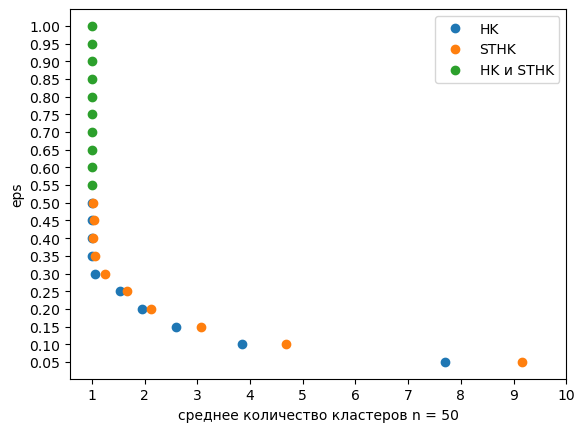

In [11]:
hk = np.array([cl_num_HK[4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[4,i]])
ek = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[4,i]]

sthk = np.array([cl_num_STHK[4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[4,i]])
est = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[4,i]]

both = np.array([cl_num_HK[4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]==cl_num_STHK[4,i]])
eb = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]==cl_num_STHK[4,i]]

plt.plot(hk/count, ek, 'o', label ="HK")
plt.plot(sthk/count, est, 'o', label = "STHK")
plt.plot(both/count, eb, 'o', label = "HK и STHK")
plt.xlabel(f'среднее количество кластеров n = {nn[4]}')
plt.ylabel('eps')
plt.xticks(range(1,11,1))
plt.yticks(ee)
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

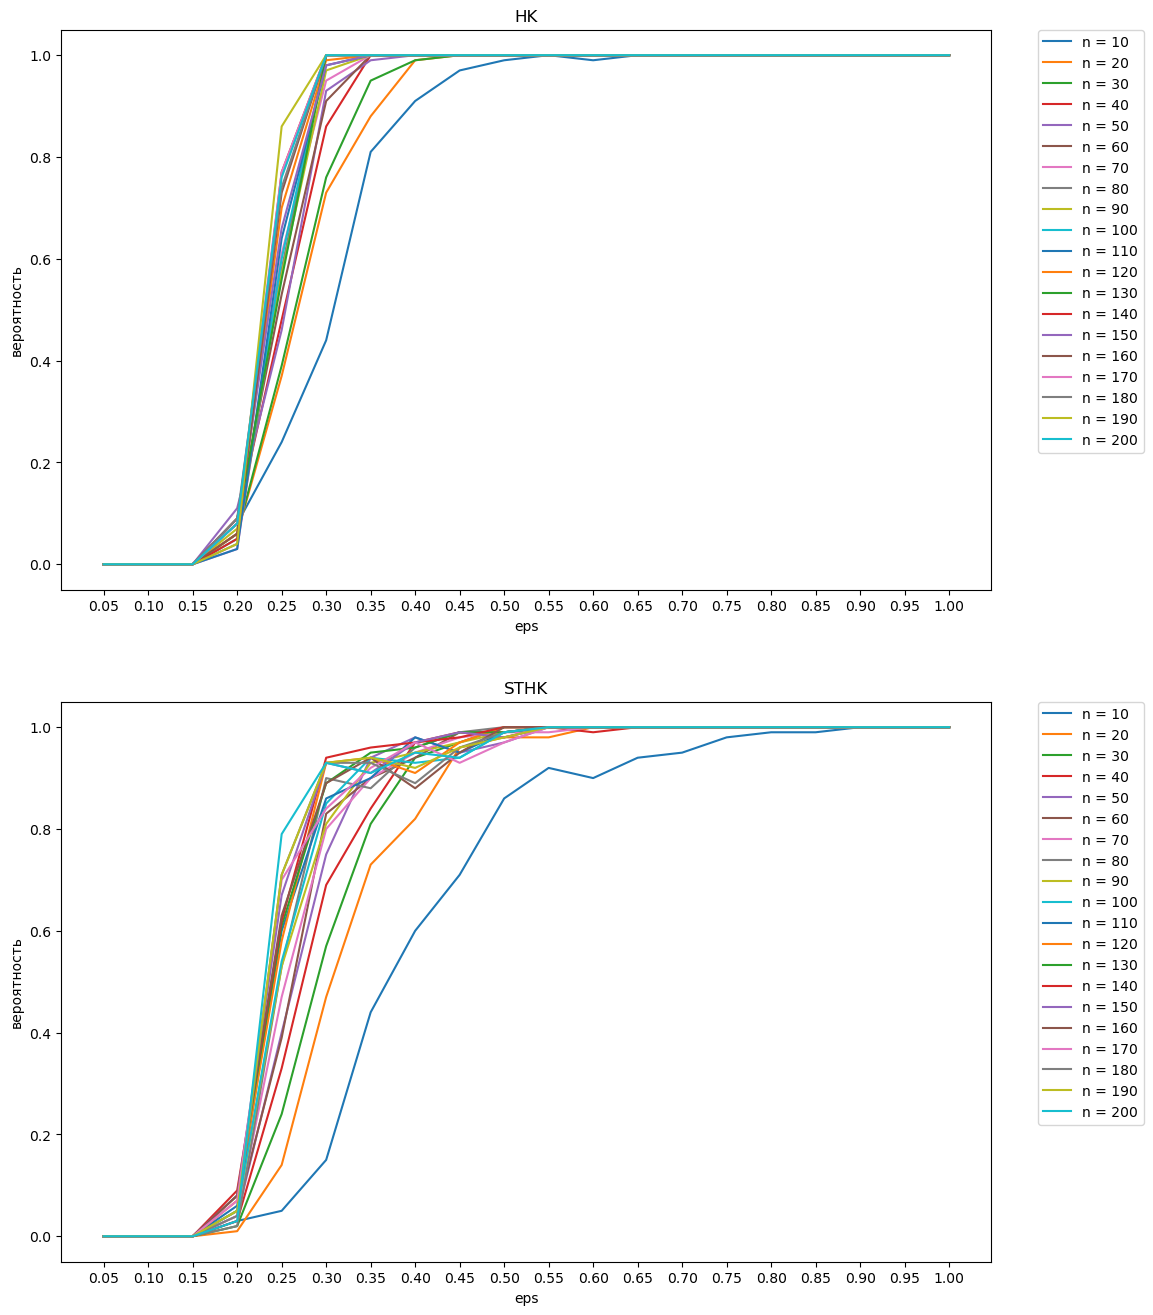

In [25]:
fig = plt.figure(facecolor='white', figsize=(12, 16))
#plt.title('зависимость вероятности получения консенсуса в в HK и STHK от eps')

ax_hk = fig.add_subplot(211)
for j in range(nn.shape[0]):
    n = nn[j]
    ax_hk.plot(ee, cl_c_col[j,:]/count, '-', label=f'n = {n}')

ax_hk.title.set_text(f'HK')
ax_hk.set_xlabel('eps')
ax_hk.set_ylabel('вероятность')
ax_hk.set_xticks(ee)
ax_hk.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

ax_sthk = fig.add_subplot(212)
for j in range(nn.shape[0]):
    n = nn[j]
    ax_sthk.plot(ee, cl_col[j,:]/count, '-', label=f'n = {n}')

ax_sthk.title.set_text(f'STHK')
ax_sthk.set_xlabel('eps')
ax_sthk.set_ylabel('вероятность')
ax_sthk.set_xticks(ee)
ax_sthk.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)


plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

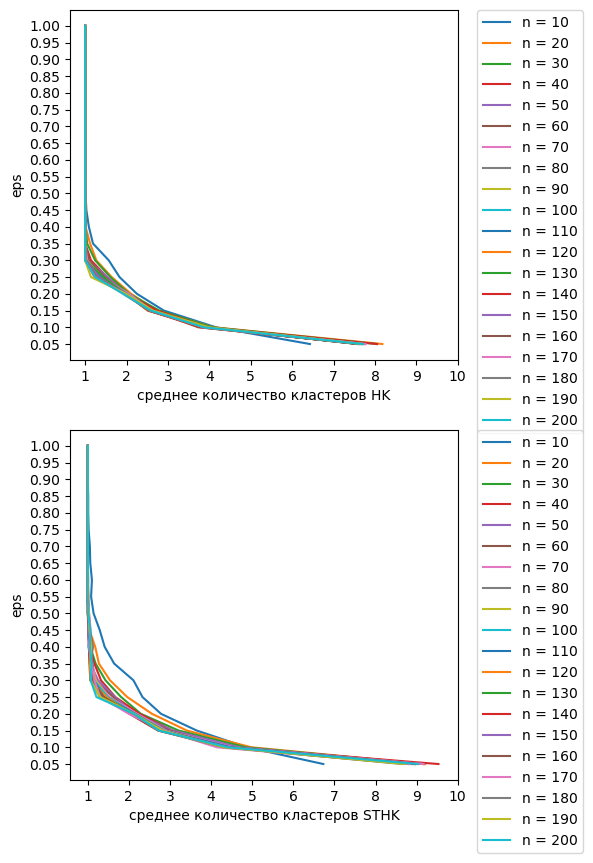

In [24]:
fig = plt.figure(facecolor='white', figsize=(5, 10))
#plt.title('зависимость вероятности получения консенсуса в в HK и STHK от eps')

ax_hk = fig.add_subplot(211)
for j in range(nn.shape[0]):
    n = nn[j]
    ax_hk.plot(cl_num_HK[j]/count, ee, '-', label =f"n = {n}")

ax_hk.set_xlabel('среднее количество кластеров HK')
ax_hk.set_ylabel('eps')
ax_hk.set_xticks(range(1,11,1))
ax_hk.set_yticks(ee)
ax_hk.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

ax_sthk = fig.add_subplot(212)
for j in range(nn.shape[0]):
    n = nn[j]
    ax_sthk.plot(cl_num_STHK[j]/count, ee, '-', label =f"n = {n}")

ax_sthk.set_xlabel('среднее количество кластеров STHK')
ax_sthk.set_ylabel('eps')
ax_sthk.set_xticks(range(1,11,1))
ax_sthk.set_yticks(ee)
ax_sthk.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)

plt.show

In [25]:
pp = np.array(range(5,11,1))
pp = pp/10

ee = np.array(range(1,21,1))
ee = ee/20
nn = np.array(range(10,210,10))

#prob = 0.5
#n = 50
na = float('nan')
cl_num_HK = np.zeros((nn.shape[0],ee.shape[0]))
cl_num_STHK = np.zeros((pp.shape[0], nn.shape[0],ee.shape[0]))

cl_col = np.zeros((pp.shape[0], nn.shape[0],ee.shape[0]))#cl_col[i] = количество  получаемых консенсусов для eps = ee[i]
cl_c_col = np.zeros((nn.shape[0],ee.shape[0]))
cl_diff = np.zeros((pp.shape[0], nn.shape[0],ee.shape[0]))
cl_d_c = np.zeros((pp.shape[0], nn.shape[0],ee.shape[0]))

count = 100


for j in trange(nn.shape[0]):
    n = nn[j]
    for _ in range(count):
        for i in range(ee.shape[0]):
            eps = ee[i]

            x0 = np.random.sample(n)
            x0.sort()
            start = pair_count(x0)

            fix_control = set({})
            v_c = 0

            X_control, t_control = Hen_Kr(x0,eps,eps2,fix_control, v_c)
            finish_c = pair_count(X_control[t_control])

            t_c_list = np.linspace(0, t_control, t_control + 1)
            c_cl = clusters(X_control[t_control], eps, fix_control)
            
            if len(c_cl) == 1:
                cl_c_col[j,i]+=1

            cl_num_HK[j,i] +=len(c_cl)

            for k in range (pp.shape[0]):
                prob = pp[k]
                X, t, cons_value, cons_time, positive_time = Hen_Kr_actm2_statistics(x0, eps, eps2, fix_control,v_c, prob)
                cltrs = clusters(X[t],eps,fix_control)
                finish = pair_count(X[t])
                t_list = np.linspace(0, t, t + 1)
                
                if len(cltrs)==1:
                    cl_col[k,j,i] +=1
                
                cl_num_STHK[k,j,i] +=len(cltrs)
                

100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [4:27:37<00:00, 802.87s/it]


In [29]:
np.save(f'cl_num_HK_{count}.npy', cl_num_HK)
np.save(f'cl_num_STHK_{count}.npy', cl_num_STHK)

np.save(f'cl_col_{count}.npy', cl_col)
np.save(f'cl_c_col_{count}.npy', cl_c_col)

In [3]:
count = 100
pp = np.array(range(5,11,1))
pp = pp/10

ee = np.array(range(1,21,1))
ee = ee/20
nn = np.array(range(10,210,10))

cl_num_HK = np.load(f'cl_num_HK_{count}.npy', mmap_mode = 'r')
cl_num_STHK = np.load(f'cl_num_STHK_{count}.npy', mmap_mode = 'r')

cl_col = np.load(f'cl_col_{count}.npy', mmap_mode = 'r')
cl_c_col = np.load(f'cl_c_col_{count}.npy', mmap_mode = 'r')

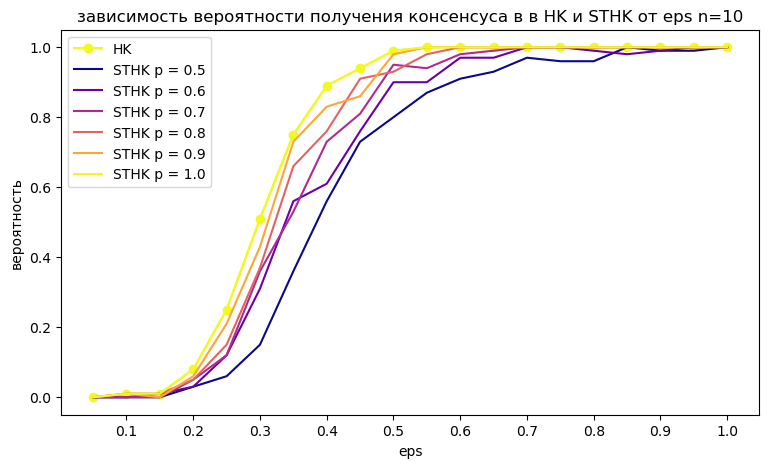

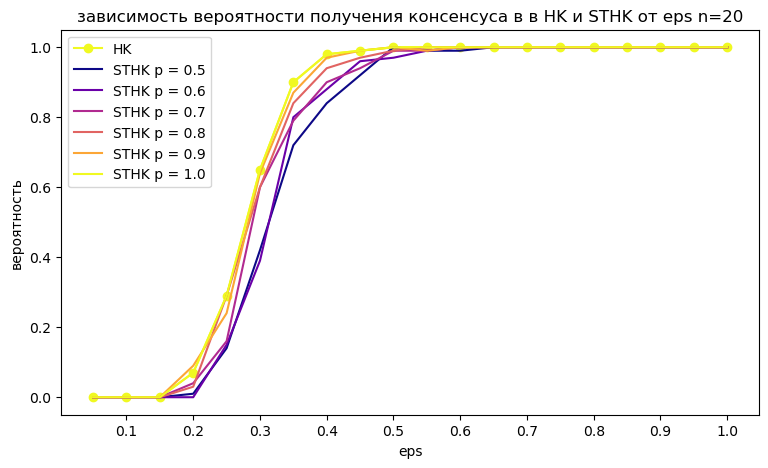

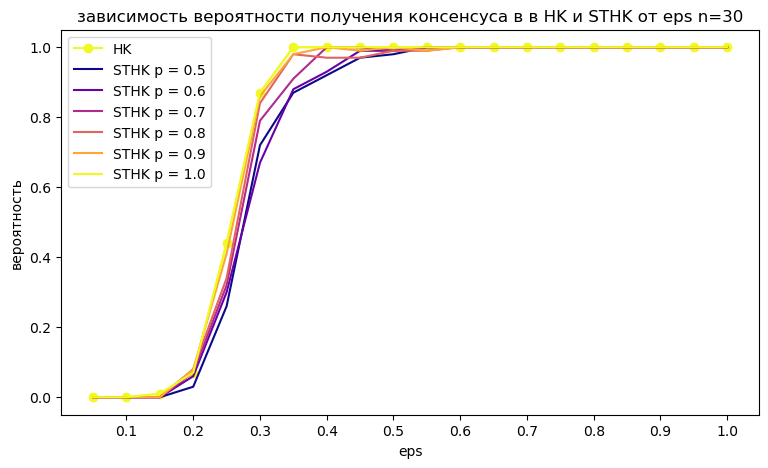

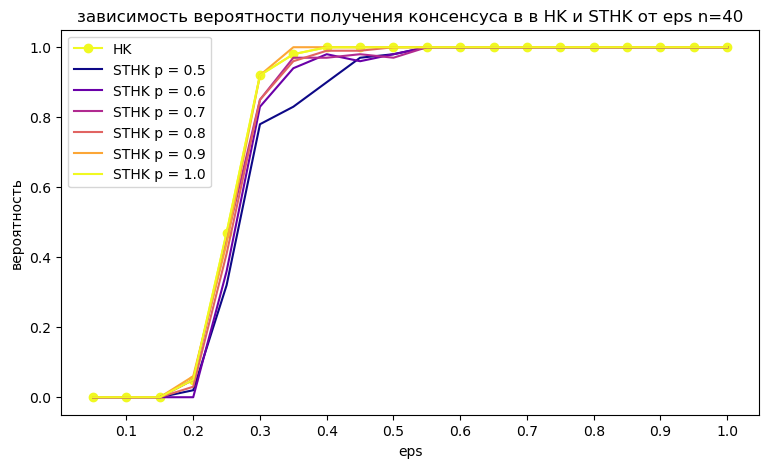

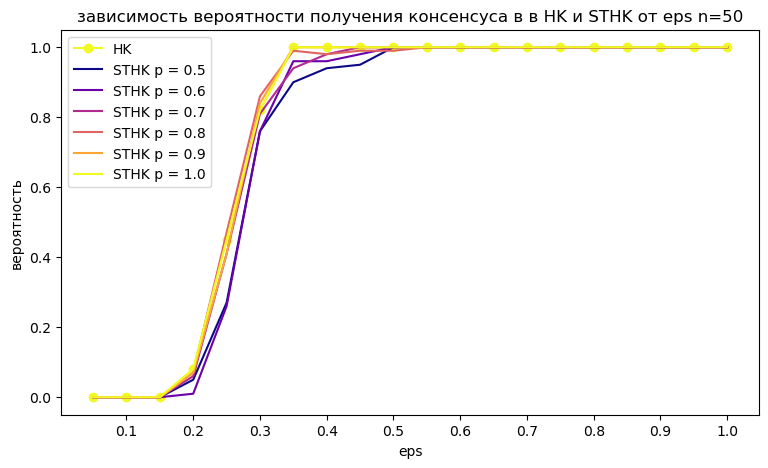

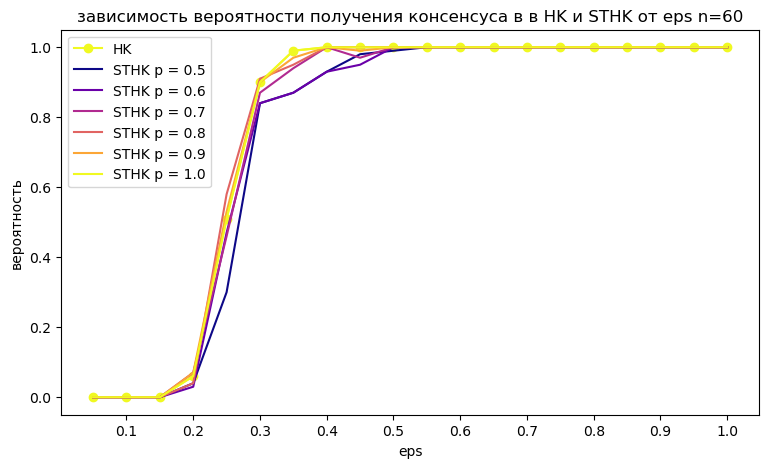

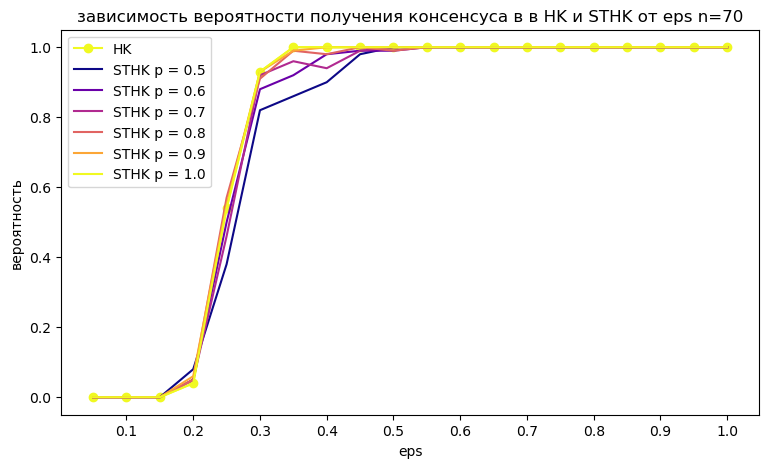

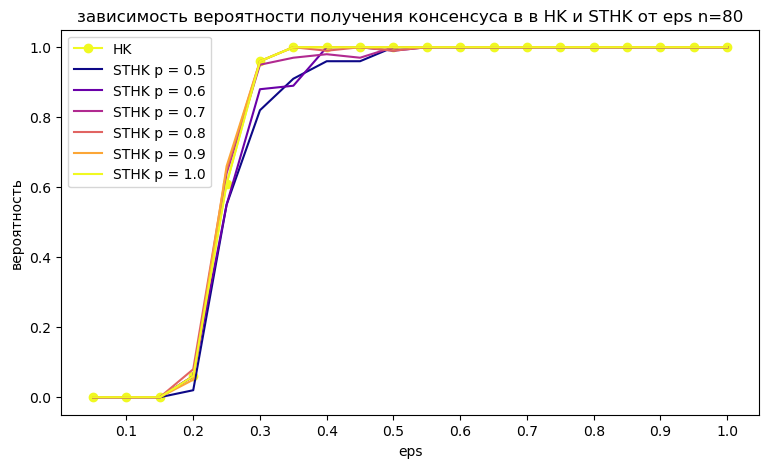

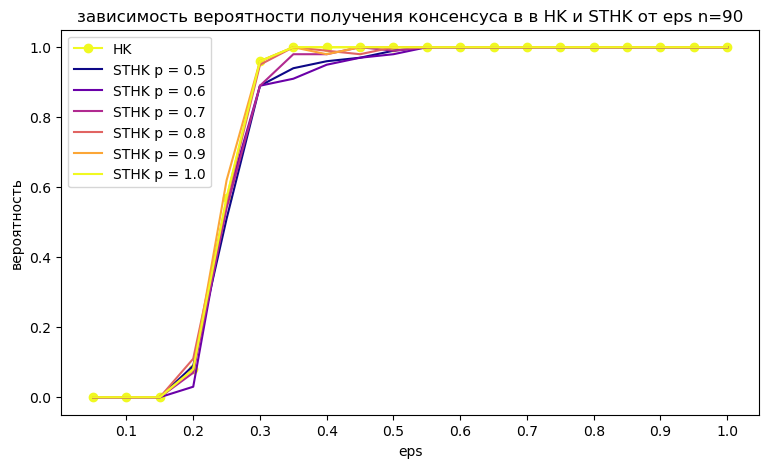

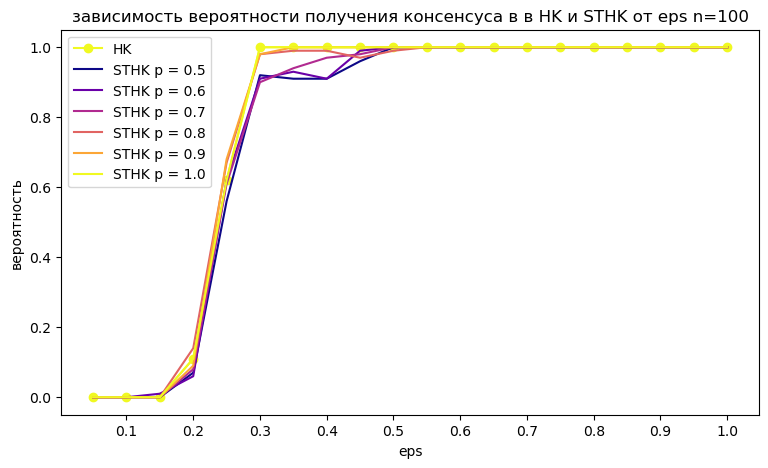

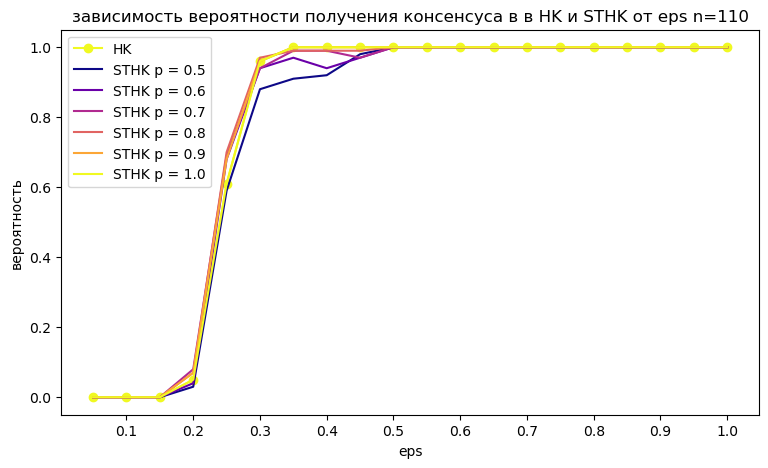

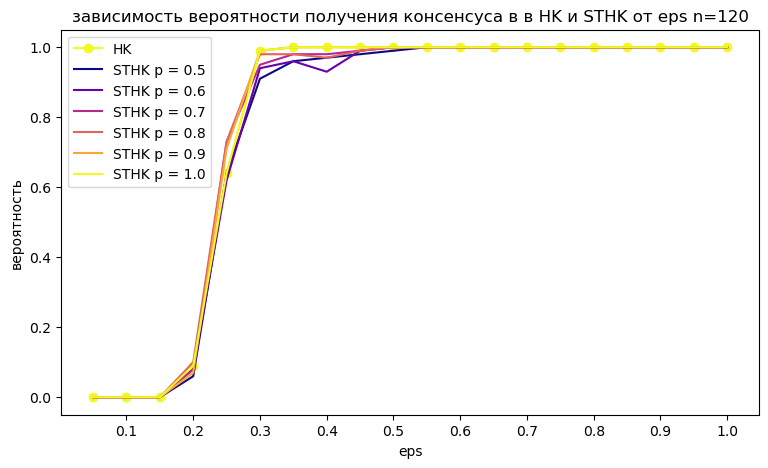

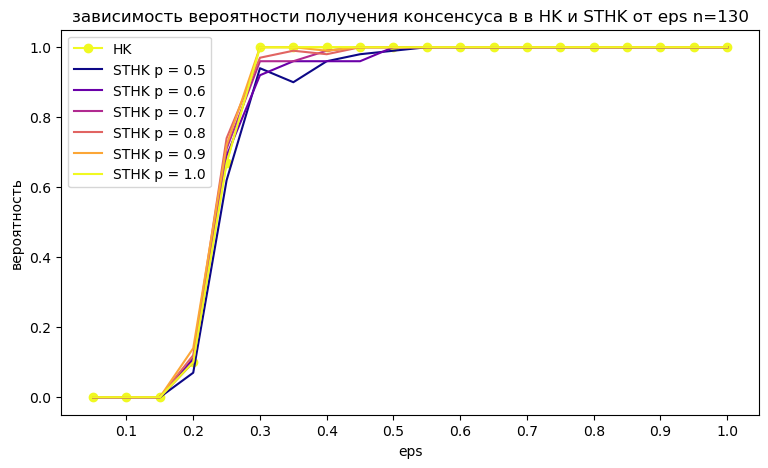

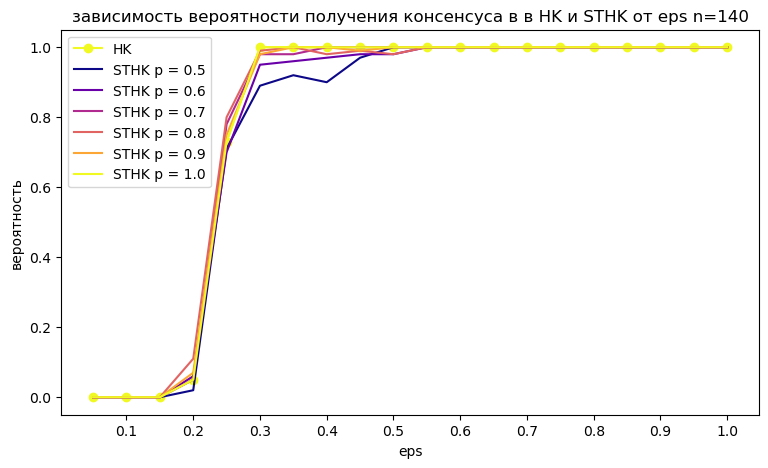

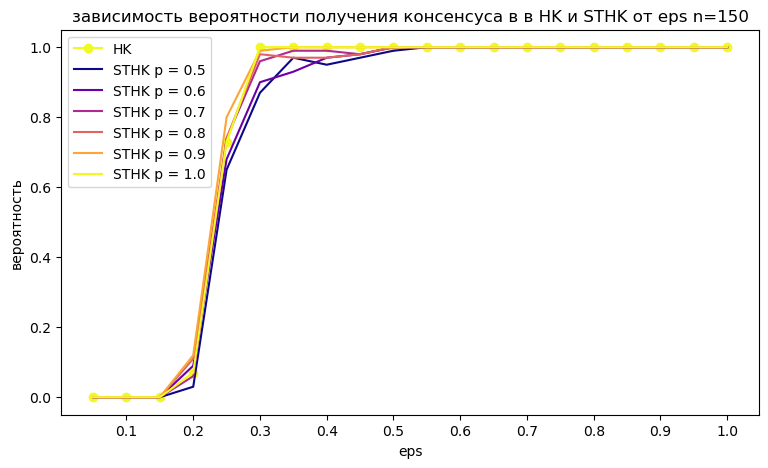

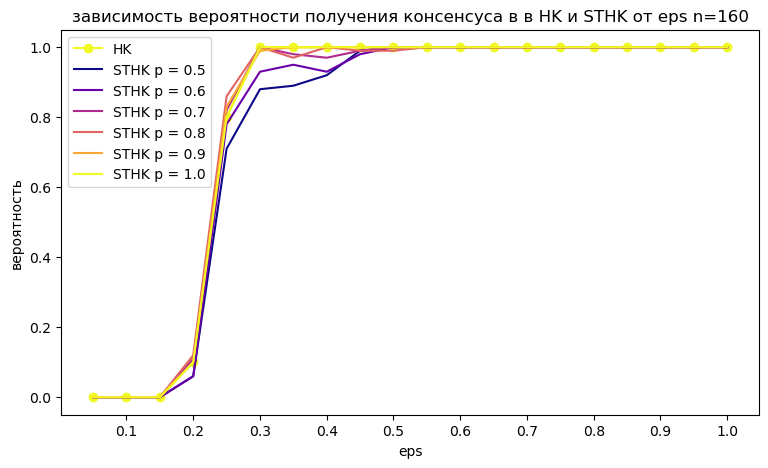

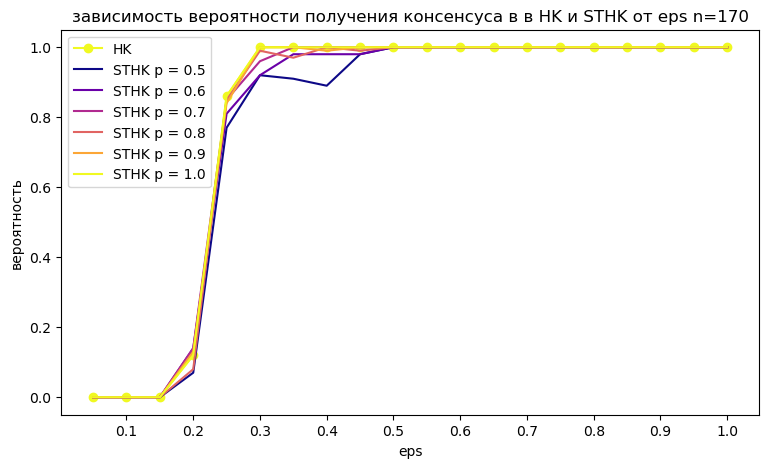

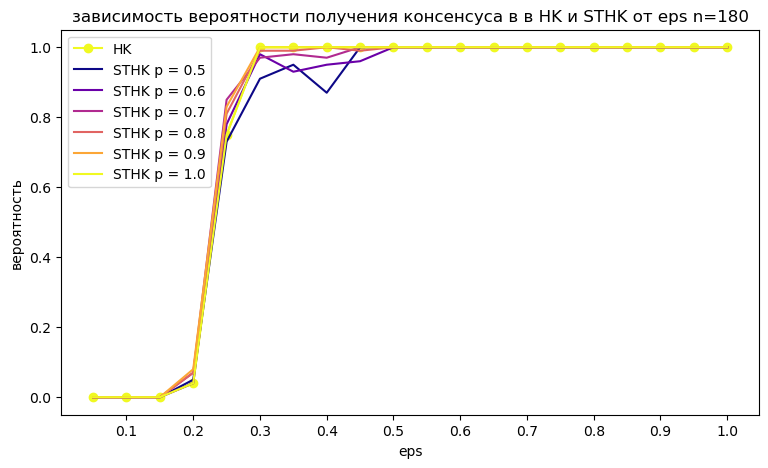

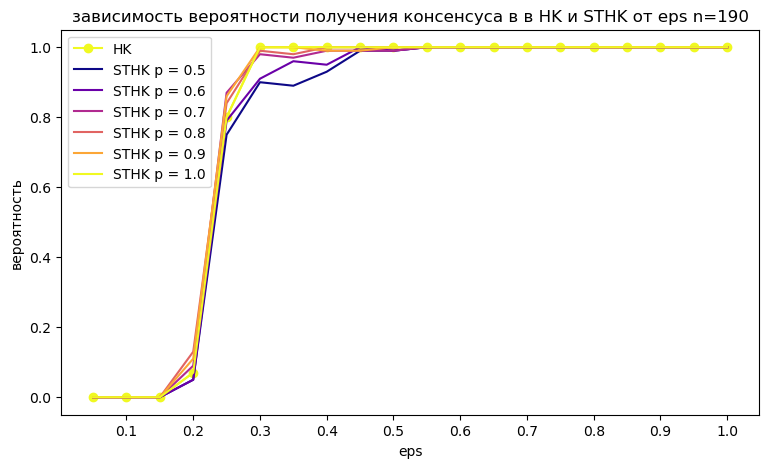

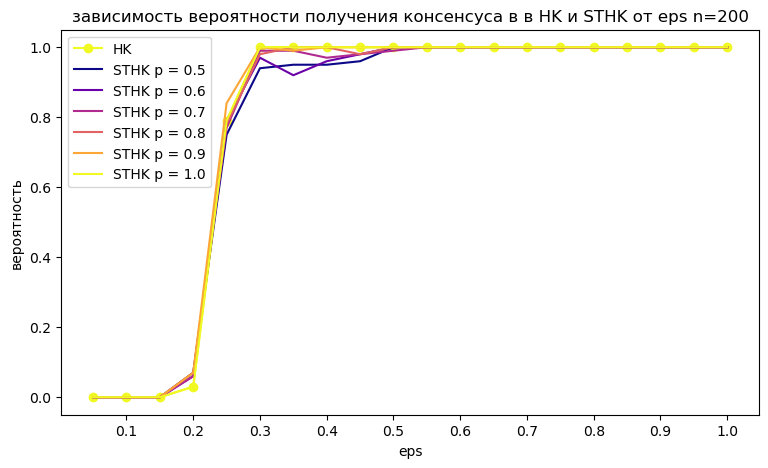

In [4]:
cmap='plasma'
cmap = mp.cm.get_cmap(cmap)
norm=plt.Normalize(vmin=min(pp), vmax=max(pp))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for j in range(ee.shape[0]):
    fig = plt.figure(facecolor='white', figsize=(9, 5))
    plt.title(f'зависимость вероятности получения консенсуса в в HK и STHK от eps n={nn[j]}')
    plt.xlabel('eps')
    plt.ylabel('вероятность')
    #plt.plot(nn, cl_num_HK/count,  '-o', label="HK")    
    plt.plot(ee, cl_c_col[j]/count,'-o', color=cmap(norm(1.)), label ='HK')
    for k in range (pp.shape[0]):
        plt.plot(ee, cl_col[k,j]/count, label=f'STHK p = {pp[k]}', color =cmap(norm(pp[k])))

    plt.legend()
    #plt.yticks(cl_col/count)
    plt.xticks(ee[1::2])
    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

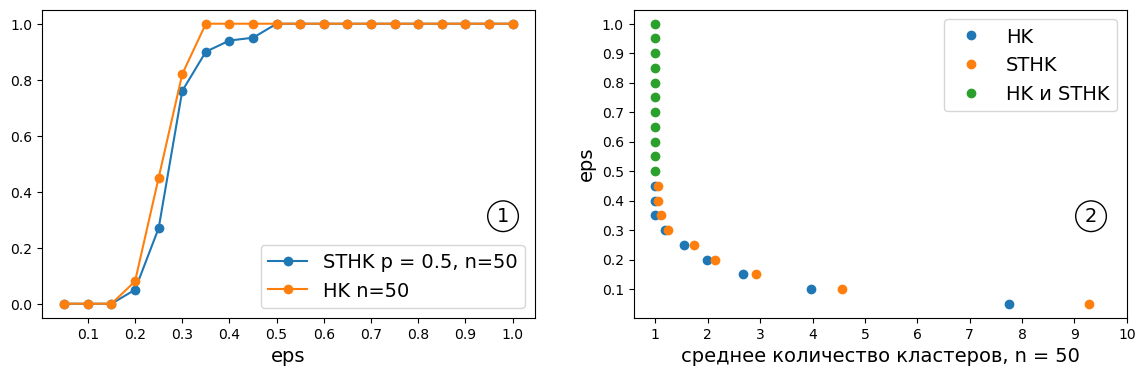

In [50]:

fig = plt.figure(facecolor='white', figsize=(14, 4))

ax1 = fig.add_subplot(121)
#plt.title(f'зависимость вероятности получения консенсуса')
ax1.set_xlabel('eps', fontsize=14)
#ax1.set_ylabel('вероятность', fontsize=14)
#plt.plot(nn, cl_num_HK/count,  '-o', label="HK")  
ax1.text(0.45,0.35,"1", transform=plt.gcf().transFigure,
         bbox={"boxstyle" : "circle", "edgecolor":"black", "facecolor":"white"}, fontsize=14)
ax1.plot(ee, cl_col[0,4]/count,'-o',label=f'STHK p = {pp[0]}, n={nn[4]}')
ax1.plot(ee, cl_c_col[4]/count,'-o', label =f'HK n={nn[4]}')
#for k in range (pp.shape[0]):


ax1.legend(fontsize=14)
#plt.yticks(cl_col/count)
ax1.set_xticks(ee[1::2])

hk = np.array([cl_num_HK[4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]])
ek = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]]

sthk = np.array([cl_num_STHK[0,4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]])
est = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]!=cl_num_STHK[0,4,i]]

both = np.array([cl_num_HK[4,i] for i in range(ee.shape[0]) if cl_num_HK[4,i]==cl_num_STHK[0,4,i]])
eb = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[4,i]==cl_num_STHK[0,4,i]]

ax2 = fig.add_subplot(122)
ax2.plot(hk/count, ek, 'o', label ="HK")
ax2.plot(sthk/count, est, 'o', label = "STHK")
ax2.plot(both/count, eb, 'o', label = "HK и STHK")
ax2.set_xlabel(f'среднее количество кластеров, n = {nn[4]}',fontsize=14)
ax2.text(0.87,0.35,"2", transform=plt.gcf().transFigure,
         bbox={"boxstyle" : "circle", "edgecolor":"black", "facecolor":"white"}, fontsize=14)
ax2.set_ylabel('eps', fontsize=14)
ax2.set_xticks(range(1,11,1))
ax2.set_yticks(ee[1::2])
ax2.legend(fontsize=14)

plt.show


In [10]:
!pip install mycolorpy

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for mycolorpy: filename=mycolorpy-1.5.1-py3-none-any.whl size=3851 sha256=7db2db9ab0dbed82166b6f6c61835fae0a93a489880aba76b3b1436b38bca99b
  Stored in directory: c:\users\anast\appdata\local\pip\cache\wheels\b9\56\d6\a163bcbec3bb69f3f7797b1b542870b18d7e31ff5dbc0b87e3
Successfully built mycolorpy


In [7]:
from mycolorpy import colorlist as mcp

<function matplotlib.pyplot.show(close=None, block=None)>

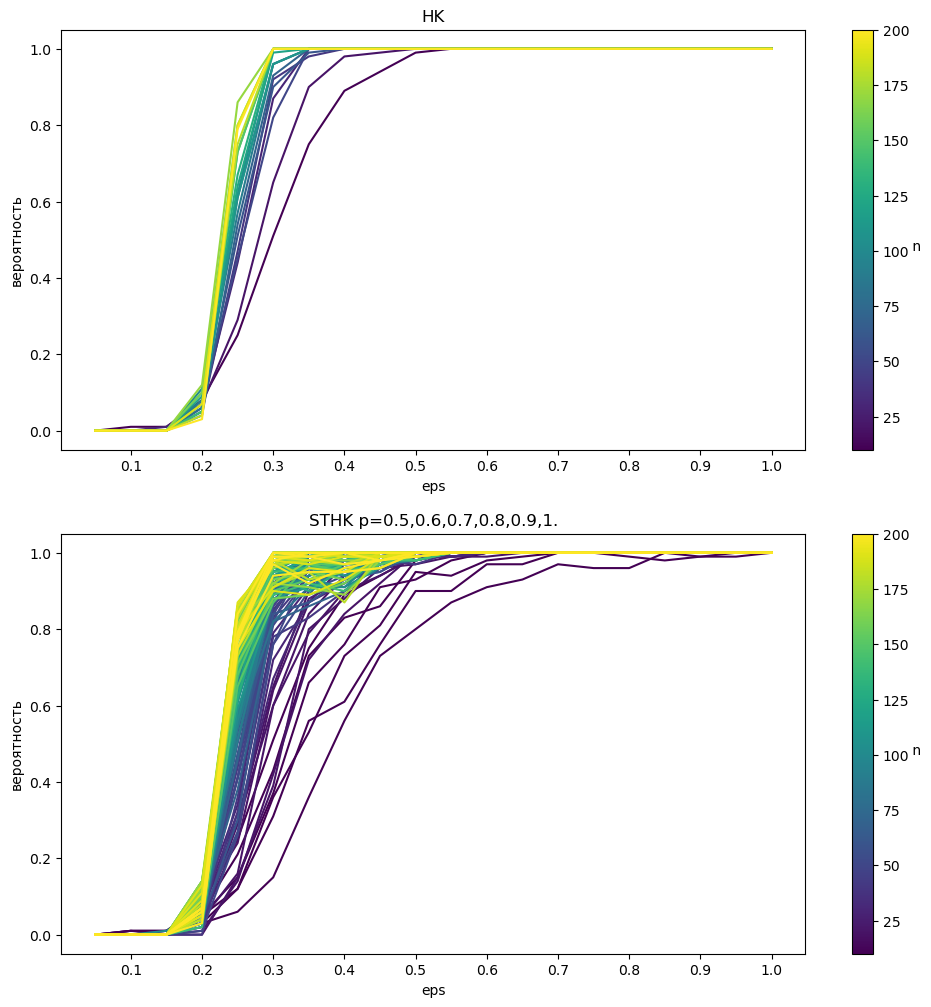

In [28]:
fig = plt.figure(facecolor='white', figsize=(12, 12))
#plt.title('зависимость вероятности получения консенсуса в в HK и STHK от eps')

cmap='viridis'
cmap = mp.cm.get_cmap(cmap)
norm=plt.Normalize(vmin=min(nn), vmax=max(nn))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

ax_hk = fig.add_subplot(211)
for j in range(nn.shape[0]):
    n = nn[j]
    ax_hk.plot(ee, cl_c_col[j,:]/count, '-', label=f'n = {n}', color=cmap(norm(n)))

ax_hk.title.set_text(f'HK')
ax_hk.set_xlabel('eps')
ax_hk.set_ylabel('вероятность')
ax_hk.set_xticks(ee[1::2])
#ax_hk.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

clb=plt.colorbar(sm, ax=ax_hk, cmap=cmap)
clb.set_label(label=' n', rotation=0., loc='center')

ax_sthk = fig.add_subplot(212)
for j in range(nn.shape[0]):
    for k in range(pp.shape[0]):
        n = nn[j]
        p = pp[k]
        ax_sthk.plot(ee, cl_col[k,j,:]/count, '-', label=f'n = {n} p = {p}', color=cmap(norm(n)))


ax_sthk.title.set_text(f'STHK p=0.5,0.6,0.7,0.8,0.9,1.')
ax_sthk.set_xlabel('eps')
ax_sthk.set_ylabel('вероятность')
ax_sthk.set_xticks(ee[1::2])
#ax_sthk.legend(bbox_to_anchor=(1.05, 1),  loc='upper left', borderaxespad=0.)
clb=plt.colorbar(sm, ax=ax_sthk, cmap=cmap)
clb.set_label(label=' n', rotation=0., loc='center')
plt.savefig(f'вероятность_конс.png', bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

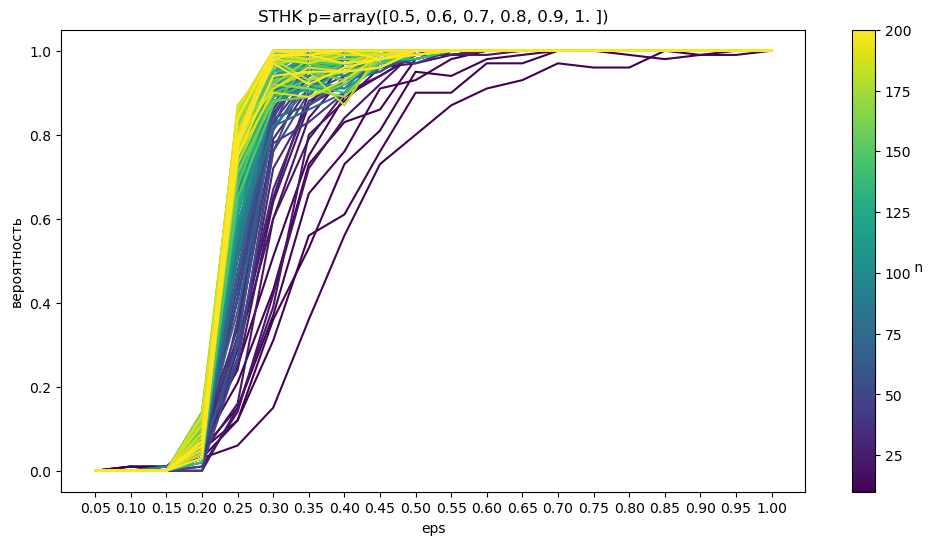

In [18]:
fig = plt.figure(facecolor='white', figsize=(12, 6))
#plt.title('зависимость вероятности получения консенсуса в в HK и STHK от eps')

cmap='viridis'
cmap = mp.cm.get_cmap(cmap)
norm=plt.Normalize(vmin=min(nn), vmax=max(nn))
norm_p=plt.Normalize(vmin=min(pp), vmax=max(pp))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

ax_sthk = fig.add_subplot(111)
for j in range(nn.shape[0]):
    for k in range(pp.shape[0]):
        n = nn[j]
        p = pp[k]
        ax_sthk.plot(ee, cl_col[k,j,:]/count, '-', label=f'n = {n} p = {p}', color=cmap(norm(n)))

ax_sthk.title.set_text(f'STHK p={pp}')
ax_sthk.set_xlabel('eps')
ax_sthk.set_ylabel('вероятность')
ax_sthk.set_xticks(ee)
#ax_sthk.legend(bbox_to_anchor=(1.05, 1),  loc='upper left', borderaxespad=0.)
clb=plt.colorbar(sm, ax=ax_sthk, cmap=cmap)
clb.set_label(label=' n', rotation=0., loc='center')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

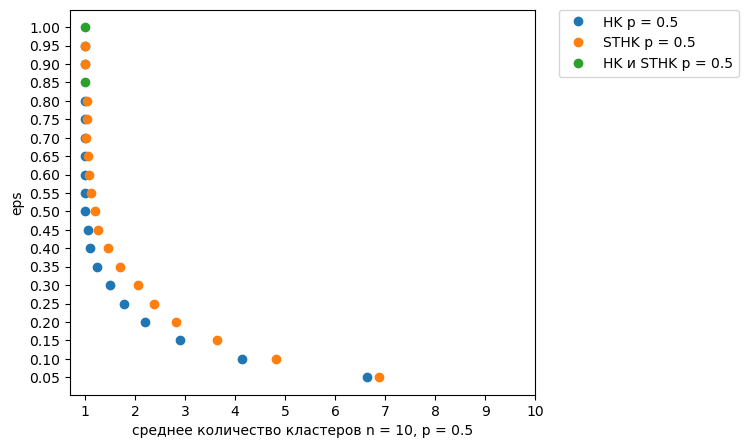

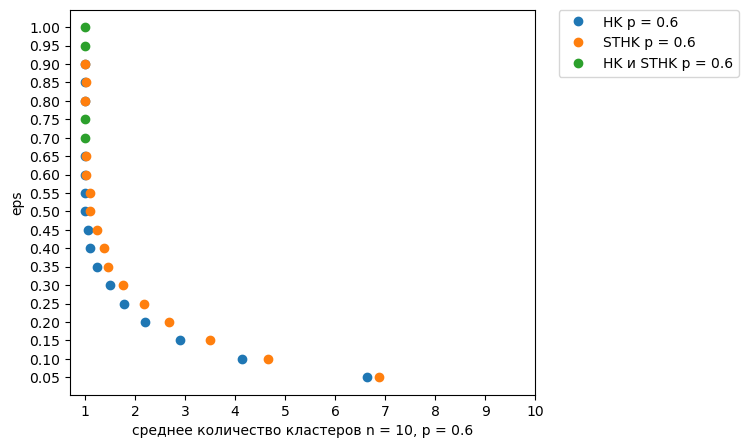

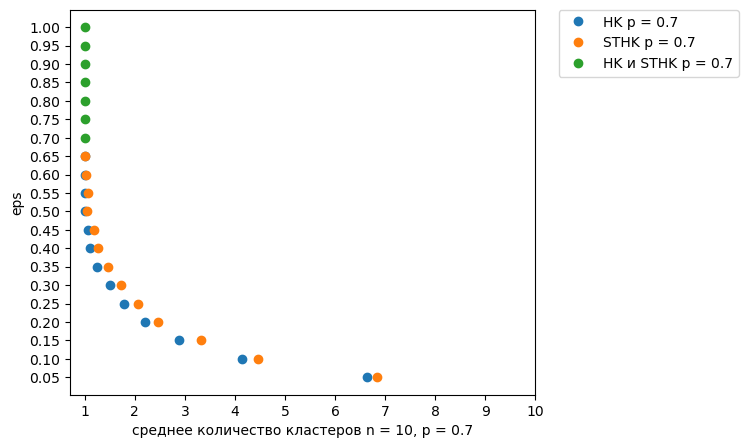

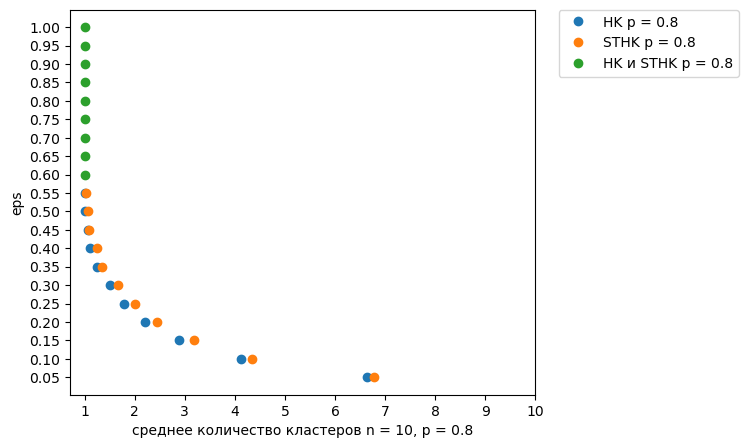

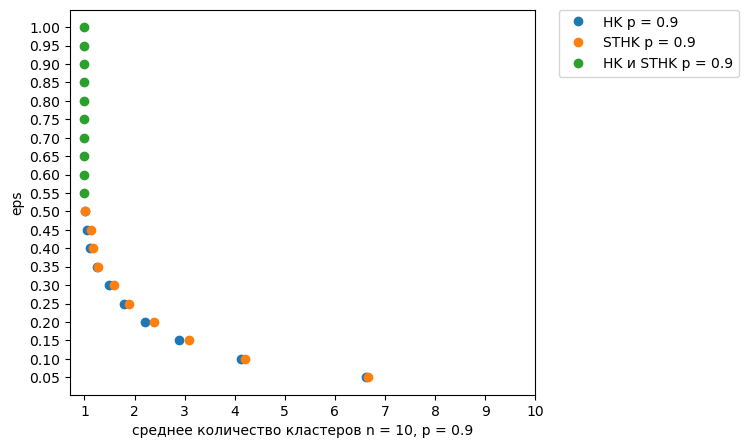

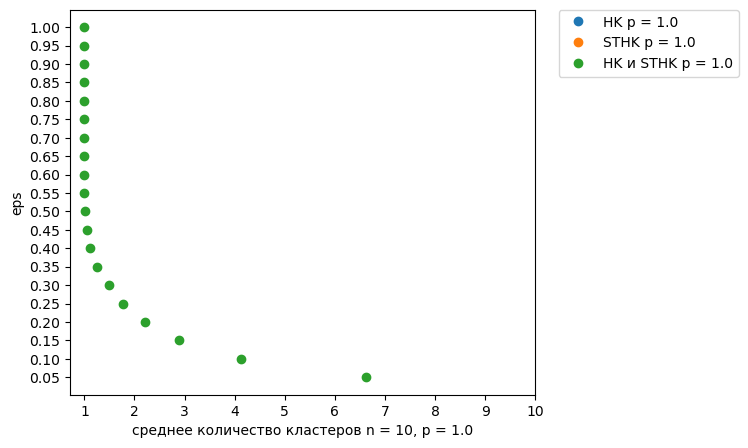

In [10]:
for k in range (pp.shape[0]):
    hk = np.array([cl_num_HK[0,i] for i in range(ee.shape[0]) if cl_num_HK[0,i]!=cl_num_STHK[k,0,i]])
    ek = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[0,i]!=cl_num_STHK[k,0,i]]

    sthk = np.array([cl_num_STHK[k,0,i] for i in range(ee.shape[0]) if cl_num_HK[0,i]!=cl_num_STHK[k,0,i]])
    est = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[0,i]!=cl_num_STHK[k,0,i]]

    both = np.array([cl_num_HK[0,i] for i in range(ee.shape[0]) if cl_num_HK[0,i]==cl_num_STHK[k,0,i]])
    eb = [ee[i] for i in range(ee.shape[0]) if cl_num_HK[0,i]==cl_num_STHK[k,0,i]]
    
    fig = plt.figure(facecolor='white', figsize=(6, 5))

    plt.plot(hk/count, ek, 'o', label =f"HK p = {pp[k]}")
    plt.plot(sthk/count, est, 'o', label = f"STHK p = {pp[k]}")
    plt.plot(both/count, eb, 'o', label = f"HK и STHK p = {pp[k]}")
    plt.xlabel(f'среднее количество кластеров n = {nn[0]}, p = {pp[k]}')
    plt.ylabel('eps')
    plt.xticks(range(1,11,1))
    plt.yticks(ee)
    plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
    
plt.show